# Perspective Correction Evaluation
The purpose of this Notebook is to evaluate different approaches of Perspective Correction and determine their suitability for PCB Defect Detection.

## Imports

In [8]:
import pandas as pd
import os 
import numpy as np
import random
import cv2
import matplotlib.pyplot as plt
import importlib

import python_code.utils.pcb_visualization as pcb_visualization

ROOT_DIR = os.path.join(os.curdir, '..', '..')

In [2]:
importlib.reload(pcb_visualization)
pcb_visualizer = pcb_visualization.PCBVisualizer()

### Initialization

In [2]:
ROOT_DIR = os.path.join(os.curdir, '..', '..')
pcb_visualizer = pcb_visualization.PCBVisualizer()

## Plotting Function

In [21]:
def plot_images(image_list, title="Images"):
    """
    Plots up to 9 images from the given list of images.
    
    Parameters:
    - image_list: List containing the images.
    - title: Plot title. Defaults to 'Images'.
    """
    
    fig, axes = plt.subplots(3, 3, figsize=(10, 10))
    axes = axes.ravel()
    
    # Ensuring that we only take up to 9 images
    num_images = min(9, len(image_list))
    
    for i in range(num_images):
        
        # Convert the BGR image from cv2 to RGB for displaying using matplotlib
        image_data = cv2.cvtColor(image_list[i], cv2.COLOR_BGR2RGB)
        
        if image_data.ndim == 3 and image_data.shape[2] == 1:
            axes[i].imshow(np.squeeze(image_data), cmap='gray')  # use the gray colormap       
        else:
            axes[i].imshow(image_data)
            
        axes[i].axis('off')
        
    fig.suptitle(title, fontsize=20, fontweight='bold', y=0.95)
    plt.subplots_adjust(wspace=0.01, hspace=0.01)
    plt.show()

def plot_detected_corners(images, corners_list, title="Detected Corners"):
    """
    Plots up to 9 images with their detected corners from the given list of images.
    
    Parameters:
    - images: List containing the images.
    - corners_list: List of lists containing the detected corners for each image.
    - title: Plot title. Defaults to 'Detected Corners'.
    """
    
    fig, axes = plt.subplots(3, 3, figsize=(10, 10))
    axes = axes.ravel()
    
    for i in range(9):
        
        image_data = cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB)
        axes[i].imshow(image_data)
        
        # Plot the detected corners on the image

        for j, corner in enumerate(corners_list[i]):
            axes[i].scatter(corner[0], corner[1], s=100, c='red', marker='o')
            axes[i].text(corner[0], corner[1], str(j), color='yellow')
            
        axes[i].set_title(f"Detected Corners: {len(corners_list[i])}", color='red')
        
        axes[i].axis('off')
        
    fig.suptitle(title, fontsize=20, fontweight='bold', y=0.95)
    plt.subplots_adjust(wspace=0.01, hspace=0.01)
    plt.show()


### Load Data

In [5]:
paths = []
targets = []

# Append Kaggle Dataset
KAGGLE_ANNO = os.path.join(ROOT_DIR, r'data/pcb_defects_kaggle/Annotations/annotation_summary.csv')

kaggle_data = pd.read_csv(KAGGLE_ANNO, sep=';') 

for _, sample in kaggle_data.iterrows():
    if sample['path'] not in paths:
        paths.append(os.path.join(ROOT_DIR, sample['path']))

#TODO: Append additional Datasets here.

# Shuffle
indices = list(range(len(paths)))
random.seed(34)  
random.shuffle(indices)
shuffled_paths = [paths[i] for i in indices[:9]]
images = [cv2.imread(path) for path in shuffled_paths]

In [17]:
warped_images = []
corners_list = []
for image in images:
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    dst = cv2.cornerHarris(image, 2, 3, 0.04)  # Harris Algorithm.
    dst = cv2.dilate(dst, None)
    _, dst = cv2.threshold(dst, 0.9999 * dst.max(), 255, 0)
    corners = np.argwhere(dst)

    corners = np.intp(corners).reshape(-1, 2)
    
    sorted_corners = corners[np.argsort(corners[:, 1])]
    corners_list.append(sorted_corners)

    #If we do not get exactly 4 corners, return the original image
    if corners is None or len(corners) != 4:
        print('Number of detected Corners: ', len(corners))
        continue
    
    print('Top Left: ', sorted_corners[1], 'Top Right: ', sorted_corners[0], 'Bottom Left: ', sorted_corners[3], 'Bottom Right: ', sorted_corners[2])

    width_top = np.linalg.norm(sorted_corners[0] - sorted_corners[1])
    width_bottom = np.linalg.norm(sorted_corners[2] - sorted_corners[3])
    height_left = np.linalg.norm(sorted_corners[0] - sorted_corners[2])
    height_right = np.linalg.norm(sorted_corners[1] - sorted_corners[3])

    detected_width = (width_top + width_bottom) / 2
    detected_height = (height_left + height_right) / 2
    aspect_ratio = detected_width / detected_height

    # Determine dimensions for the desired rectangle
    if aspect_ratio > 1:
        desired_width = int(detected_width)
        desired_height = int(desired_width / aspect_ratio)
    else:
        desired_height = int(detected_height)
        desired_width = int(desired_height * aspect_ratio)

    desired_corners = np.array([
        [0, 0],
        [desired_width-1, 0],
        [0, desired_height-1],
        [desired_width-1, desired_height-1]
    ], dtype='float32')
    
    M = cv2.getPerspectiveTransform(np.float32(sorted_corners), desired_corners)
    warped_images.append(cv2.warpPerspective(image, M, (desired_width, desired_height)))

Number of detected Corners:  9
Number of detected Corners:  9
Number of detected Corners:  9
Number of detected Corners:  9
Number of detected Corners:  9
Number of detected Corners:  9
Number of detected Corners:  9
Number of detected Corners:  9
Number of detected Corners:  9


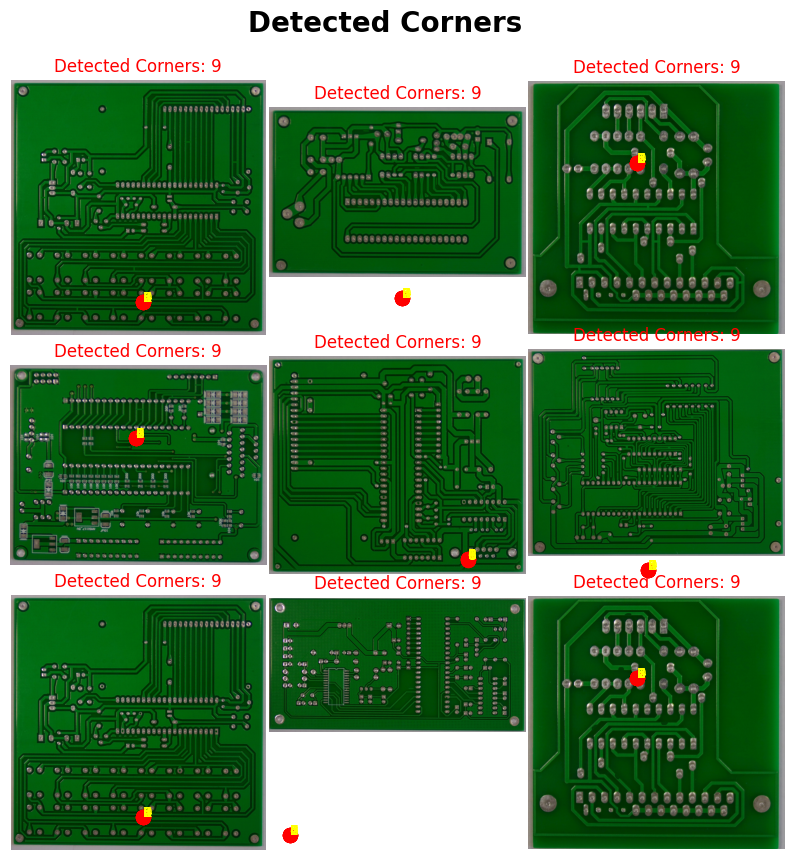

In [22]:
plot_detected_corners(images, corners_list)